<a href="https://colab.research.google.com/github/cmannnn/language_classifier/blob/main/language_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Language Classifier

##Imports

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 35.8 MB/s 
     |████████████████████████████████| 1.2 MB 54.3 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 188 kB 41.2 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 51 kB 366 kB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

##Bing image search

In [4]:
# getting Azure Bing search key and setting it to key
key = os.environ.get('AZURE_SEARCH_KEY', 'a80b54eb571b45658bbad8530262ff7f')

In [5]:
# testing search_images_bing method to see if azure key works
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
# using key to search 'grizzly bear' into bing image search
results = search_images_bing(key, 'chinese language')

# grabbing the url's of the results
ims = results.attrgot('content_url')

# checking the length of the URL's
print(f'The number of URL\'s downloaded is: {len(ims)}')

The number of URL's downloaded is: 150


In [6]:
# one random chinese character URL
ims = ['https://thumbs.dreamstime.com/b/chinese-city-tianjin-characters-vector-illustration-151968254.jpg']

# downloading character URL
dest = 'images'
download_url(ims[0], dest)

In [7]:
# mounting Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


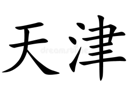

In [8]:
# opening downloaded picture as 128 x 128 rectangle 
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
# creating folder string for each language
language_types = 'korean','arabic','chinese'

# creating a new main folder in our path called 'language'
path = Path('language')

In [10]:
# loop to create new directory with 
#if not path.exists():
#    path.mkdir()
#    for o in language_types:
#        dest = (path/o)
#        dest.mkdir(exist_ok=True)
#        results = search_images_bing(key, f'{o} language')
#        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
if not path.exists():
  path.mkdir()
  dest = (path/'korean')
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'korean characters')
  download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
if not path.exists():
  path.mkdir()
  dest = (path/'chinese')
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'chinese symbols')
  download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
if not path.exists():
  path.mkdir()
  dest = (path/'arabic')
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'arabic alphabet')
  download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# chinese symbols
# korean characters
# arabic alphabet

In [11]:
# verifying there are pictures in the languages directory
fns = get_image_files(path)
fns

(#441) [Path('language/arabic/00000043.png'),Path('language/arabic/00000137.jpg'),Path('language/arabic/00000136.jpg'),Path('language/arabic/00000091.jpg'),Path('language/arabic/00000050.jpg'),Path('language/arabic/00000003.jpg'),Path('language/arabic/00000004.png'),Path('language/arabic/00000010.jpg'),Path('language/arabic/00000007.jpeg'),Path('language/arabic/00000111.jpg')...]

In [12]:
# checking if any images are corrupted
failed = verify_images(fns)
failed

# removing any corrupted files
failed.map(Path.unlink)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#16) [None,None,None,None,None,None,None,None,None,None...]

In [13]:
# creating categorical datablock, identify independent/dependent variables, randomly splitting 20%, 
# using subfolder name as the y value, and resizing the pictures to 128 squares 
languaes = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 14),
    get_y = parent_label,
    item_tfms = Resize(128))

In [14]:
# defining the images source
dls = languaes.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


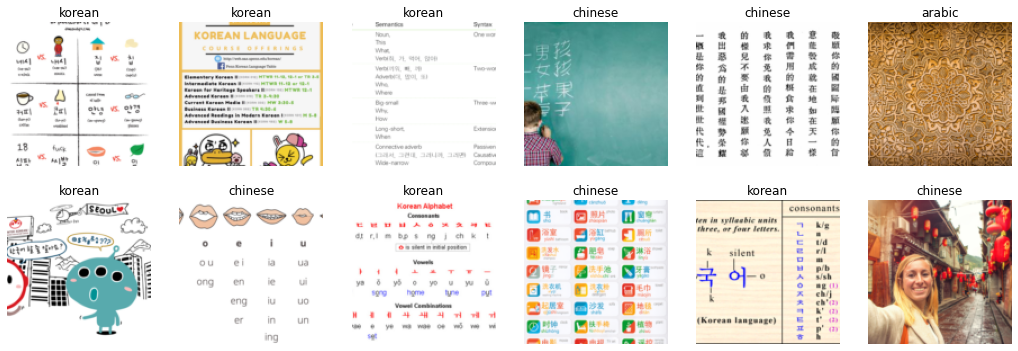

In [15]:
# showing 12 images
dls.valid.show_batch(max_n = 12, nrows = 2)

In [ ]:
# going with randomly resizing to 224 x 224, cropping with parameter 0.5, and augumenting 
languages = languaes.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms())

# defining the images source
dls = languages.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [ ]:
# defining learn with a pretrained resnet18 model, measuring model with error_rate
learn = cnn_learner(dls, resnet18, metrics = error_rate)

# running for 4 epochs
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.878684,1.756879,0.523810,00:10


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.481465,1.298223,0.476190,00:10
1,1.355807,1.053576,0.452381,00:10
2,1.188323,1.017675,0.476190,00:10
3,1.051629,1.036924,0.500000,00:10


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Im

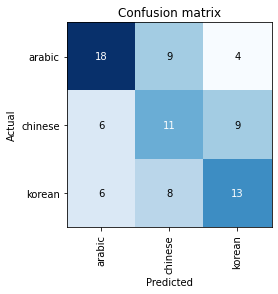

In [ ]:
# creating a confusion matrix from the model
interp = ClassificationInterpretation.from_learner(learn)

# plotting confusion matrix
interp.plot_confusion_matrix()

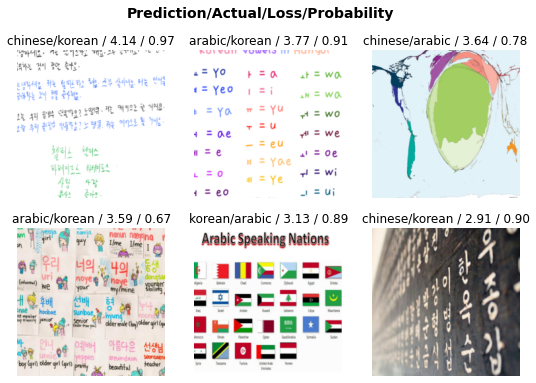

In [ ]:
# showing the models predictions with the highest loss
interp.plot_top_losses(6, nrows = 2)

In [ ]:
# running ImageClassifierCleaner GUI to remove bad images
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
